In [1]:
import mygene
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import numpy as np
import dynamo as dyn
dyn.__version__

'0.0+07100a0'

In [2]:
import pandas as pd 
from scipy.sparse import csr_matrix

In [3]:
def ensemble2gene_symbol(ensemble_names, species):
    
    mg = mygene.MyGeneInfo()
    geneSyms = mg.querymany(ensemble_names, scopes='ensembl.gene', fields='symbol', species='human',)
    var_pd = pd.DataFrame(geneSyms)

    return var_pd


In [4]:
# new_RNA = pd.read_csv('/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/GSE128273_exp1_newcounts.csv', index_col=0, delimiter=',')
# old_RNA = pd.read_csv('/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/GSE128273_exp1_oldcounts.csv', index_col=0, delimiter=',')
# tot_RNA = pd.read_csv('/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/GSE128273_exp1_readcounts.csv', index_col=0, delimiter=',')

# new_RNA.fillna(0, inplace=True)
# old_RNA.fillna(0, inplace=True)
# tot_RNA.fillna(0, inplace=True)


# new_RNA.head()

# split_array = [new_RNA.columns.str.split('_', n=5)[i] for i in range(len(new_RNA.columns.str.split('_', n=5)))]
# split_df = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', '4sU'])

# var_df_ = ensemble2gene_symbol(new_RNA.index.values, 'human')


def load_raw_data(exp, basedir = '/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/'):
    new_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_newcounts.csv', index_col=0, delimiter=',')
    old_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_oldcounts.csv', index_col=0, delimiter=',')
    tot_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_readcounts.csv', index_col=0, delimiter=',')

    new_RNA.fillna(0, inplace=True)
    old_RNA.fillna(0, inplace=True)
    tot_RNA.fillna(0, inplace=True)

    new_RNA.head()

    if exp == "1":         
        split_array = [new_RNA.columns.str.split('_', n=5)[i] for i in range(len(new_RNA.columns.str.split('_', n=5)))]
        split_df = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', '4sU'])
    else: 
        split_array = [new_RNA.columns.str.split('_', n=6)[i] for i in range(len(new_RNA.columns.str.split('_', n=6)))]
        split_df = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', '4sU', 'drug_treatment'])

    var_df_ = ensemble2gene_symbol(new_RNA.index.values, 'human')
    
    return new_RNA, old_RNA, tot_RNA, var_df_, split_df


In [5]:
new_RNA, old_RNA, tot_RNA, var_df_, split_df = load_raw_data("1", basedir = '/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/')



querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [6]:
import time
from anndata import AnnData

exp1_gene_list = ["MYC", "PDLIM5", "GAPDH"]
exp2_gene_list = ["EGR1", "FOS", "GAPDH", "ACTB"]
color = 'Exp'
basis = 'umap'

def dynamo_analysis(adata, genes, color):
#     adata.layers['new'], adata.layers['total'] = csr_matrix(adata.layers['unspliced']), csr_matrix(
#         adata.layers['spliced'])
#     del adata.layers['unspliced'], adata.layers['spliced']
    adata.obs.loc[:, 't'] = adata.obs.loc[:, '4sU']
    adata.obs.loc[:, 't'] = adata.obs.loc[:, 't'].map({"30min4sU": 0.5, "60min4sU": 1, "control": 0, "unlabelled": 0})

    # normalization
    dyn.pp.recipe_monocle(adata, n_top_genes=2000)

    # smoothing (calculate 1/2 moments); calculate kinetic parameters and high dimensional velocity vector
    start_time = time.time()
    dyn.tl.dynamics(adata, filter_gene_mode='final', mode='moment')
    print("--- %s seconds ---" % (time.time() - start_time))
    print("experiment type is ", adata.uns['dynamics']["experiment_type"])

    dyn.tl.reduceDimension(adata, reduction_method='umap')

    # velocity on new data; new_umap: new layer
    dyn.tl.cell_velocities(adata, n_recurse_neighbors=2, M_diff=0.2, epsilon=None, adaptive_local_kernel=True, tol=1e-7)
    dyn.pl.cell_wise_velocity(adata, color=['4sU'], ncols=3, pointsize=5, basis='new_umap', figsize=(3, 3), alpha=0.6)

    # velocity on total data; new_umap: new layer
    dyn.tl.cell_velocities(adata, n_recurse_neighbors=2, M_diff=0.2, epsilon=None, adaptive_local_kernel=True, tol=1e-7,
                           ekey='X_total', vkey='velocity_S', min_r2=-10)
    dyn.pl.cell_wise_velocity(adata, color=['4sU'], ncols=3, pointsize=5, basis='umap', figsize=(3, 3), alpha=0.6)

    # subset cells with 4sU
    fourSU = adata[adata.obs.loc[:, '4sU'] == '60min4sU', :]
    dyn.pl.cell_wise_velocity(fourSU, color=['4sU'], ncols=3, pointsize=5, basis='new_umap', figsize=(3, 3), alpha=0.6)

    # subset cells without 4sU
    non_fourSU = adata[adata.obs.loc[:, '4sU'] != '60min4sU', :]
    dyn.pl.cell_wise_velocity(non_fourSU, color=['4sU'], ncols=3, pointsize=5, basis='new_umap', figsize=(3, 3), alpha=0.6)

    genes = adata.var_names[adata.var_names.isin(genes)].tolist()
    if len(genes) == 0: genes = adata.var_names[adata.var.use_for_velocity].tolist()[:3]
    genes.append(color)                         
    # different embedding plot
    dyn.pl.pca(adata, color=exp1_gene_list, ncols=3, pointsize=5, figsize=(3, 3))
    dyn.pl.umap(adata, color=exp1_gene_list, ncols=3, pointsize=5, figsize=(3, 3))
    dyn.pl.trimap(adata, color=exp1_gene_list, ncols=3, pointsize=5, figsize=(3, 3))

    # plot phase portrait
    dyn.pl.phase_portraits(adata, genes=adata.var.index[adata.var.use_for_velocity][:3], ncols=3, figsize=(3, 3))

    # grid velocity
    dyn.pl.grid_velocity(adata, color=exp1_gene_list, ncols=3, pointsize=5, basis=basis, figsize=(3, 3))
    # streamline plot
    dyn.pl.streamline_plot(adata, color=exp1_gene_list, ncols=3, pointsize=5, basis=basis, figsize=(3, 3),
                           method='gaussian', min_mass=1e-3)

    dyn.tl.VectorField(adata, basis=basis, dims=[0, 1])

    dyn.pl.topography(adata, color=['4sU'], basis=basis, figsize=(3, 3))

    # plot phase but with the dot (n) and dot (t)
    gene = adata.var.index[adata.var.use_for_velocity][0]
    X, Y, V, F = adata[:, gene].layers['M_t'], adata[:, gene].layers['M_n'], \
                 adata[:, gene].layers['velocity_S'], adata[:, gene].layers['velocity_U']

    def one_shot_k(gamma, t):
        k = 1 - np.exp(- gamma * t)
        return k

    k = one_shot_k(adata[:, gene].var['gamma'][0], 1)
    X, Y, V, F = X.A, Y.A, V.A, F.A
    # F[F > 0] = 0
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(X, Y)
    ax.quiver(X, Y, V, F)
    xnew = np.linspace(0, X.max())
    ax.plot(xnew, xnew * k, c='red')
    plt.show()


In [7]:
var = pd.DataFrame(new_RNA.index)
var.columns = ['id']
var_df = var_df_.loc[~ var_df_.loc[:, 'query'].duplicated(), :]

var = var.merge(var_df, left_on='id', right_on='query', )

var_df = var_df.set_index('query')
var_df = var_df.loc[new_RNA.index, :]
var_df = var_df.set_index('symbol')

dyn_adata_NASC_seq_1 = AnnData(csr_matrix(tot_RNA.values.T),
    obs = split_df,
    var = var_df, 
    layers=dict(
        new=csr_matrix(new_RNA.values.T),
        total = csr_matrix(tot_RNA.values.T))) 

dyn_adata_NASC_seq_1

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 192 × 58428 
    obs: 'Plate', 'Well', 'Exp', 'CellType', '4sU'
    var: '_id', '_score', 'notfound'
    layers: 'new', 'total'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+07100a0-py3.6.egg/dynamo/tools/utils.py:265: UserWarning: dynamo finds that your data has labeling, but you didn't provide a `tkey` formetabolic labeling experiments, so experiment_type is set to be `one-shot`.
  warnings.warn("dynamo finds that your data has labeling, but you didn't provide a `tkey` for"
/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+07100a0-py3.6.egg/dynamo/tools/dynamics.py:102: UserWarning: dynamo detects the experiment type of your data as one-shot, but your input experiment_type is None
  'is {}'.format(exp_type, experiment_type))
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


--- 15.959948062896729 seconds ---
experiment type is  one-shot


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 432x288 with 0 Axes>

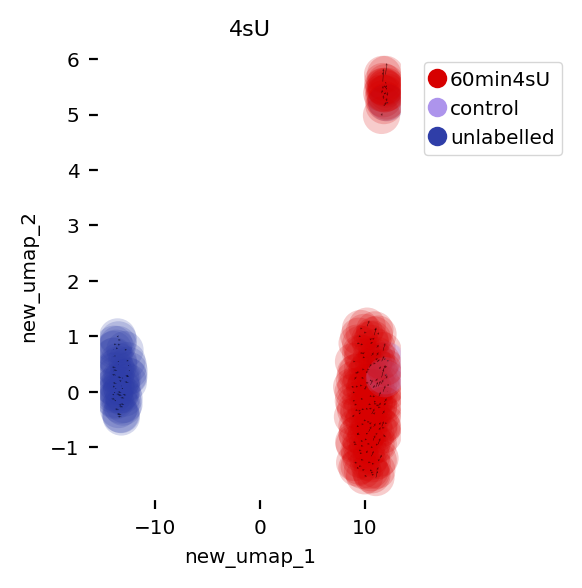

/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 650x500 with 0 Axes>

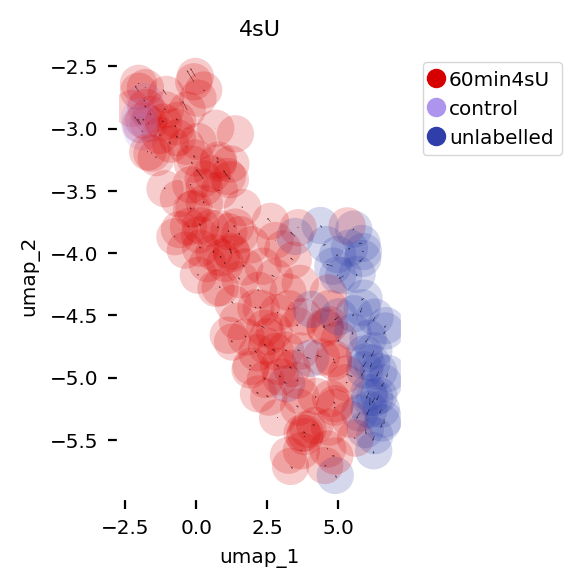

<Figure size 650x500 with 0 Axes>

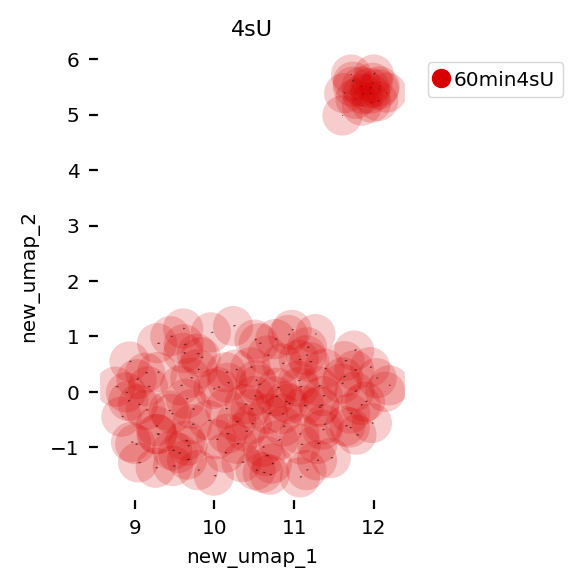

<Figure size 650x500 with 0 Axes>

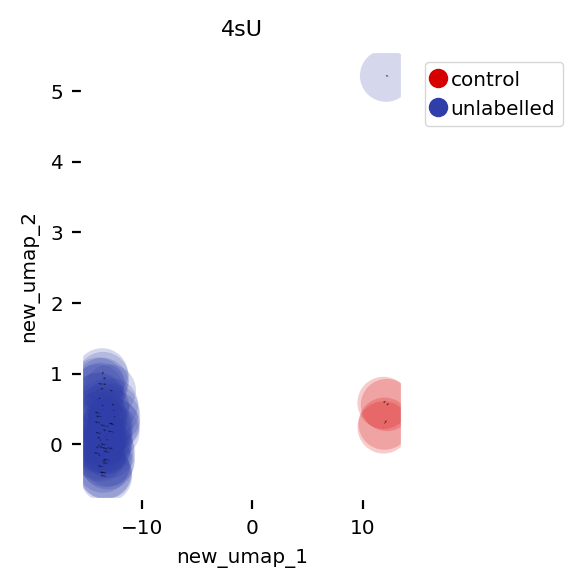

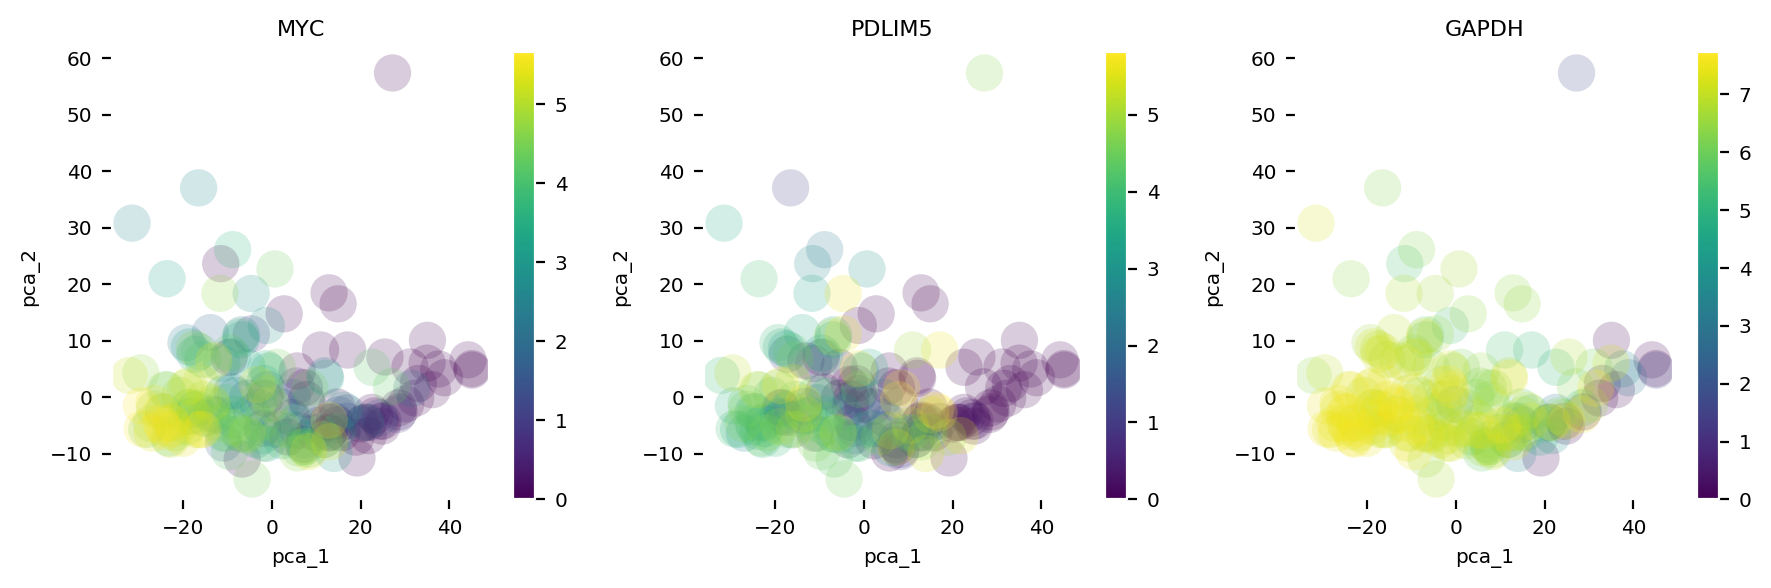

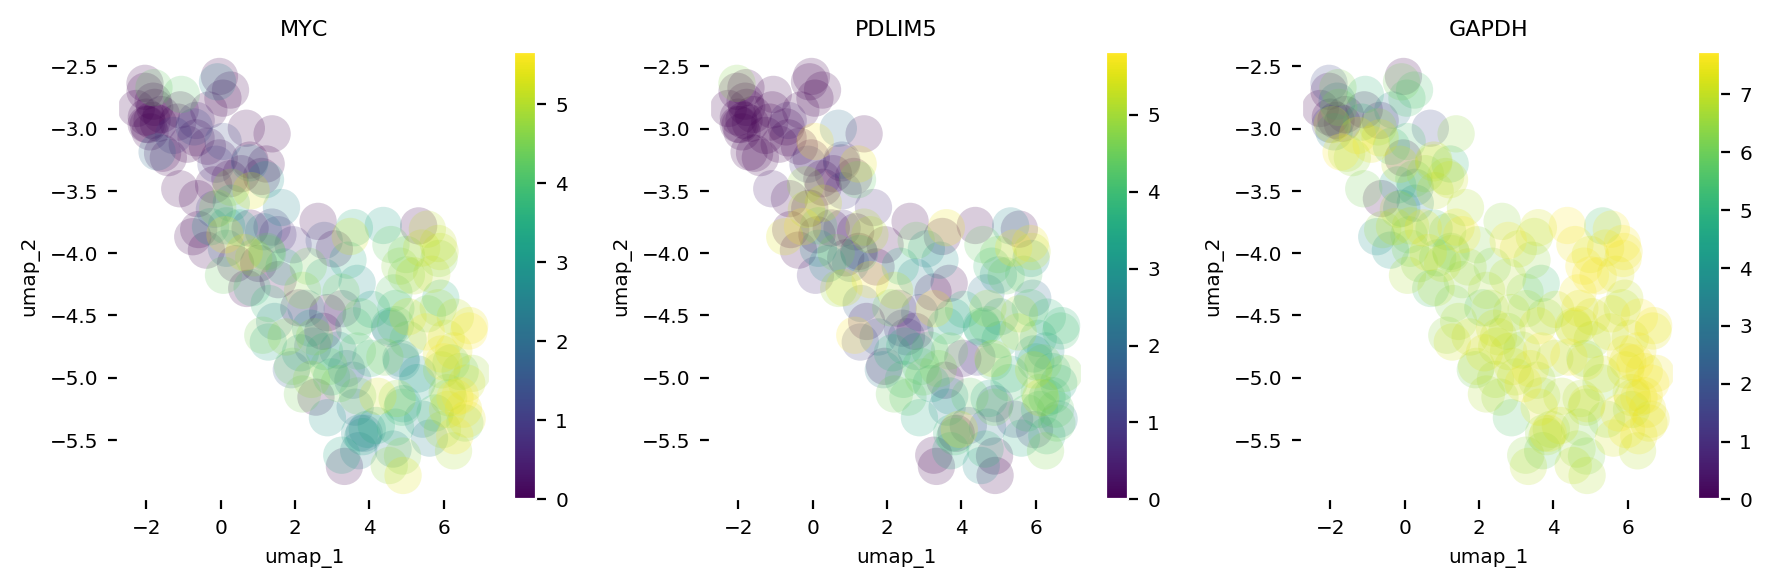

<Figure size 900x300 with 0 Axes>

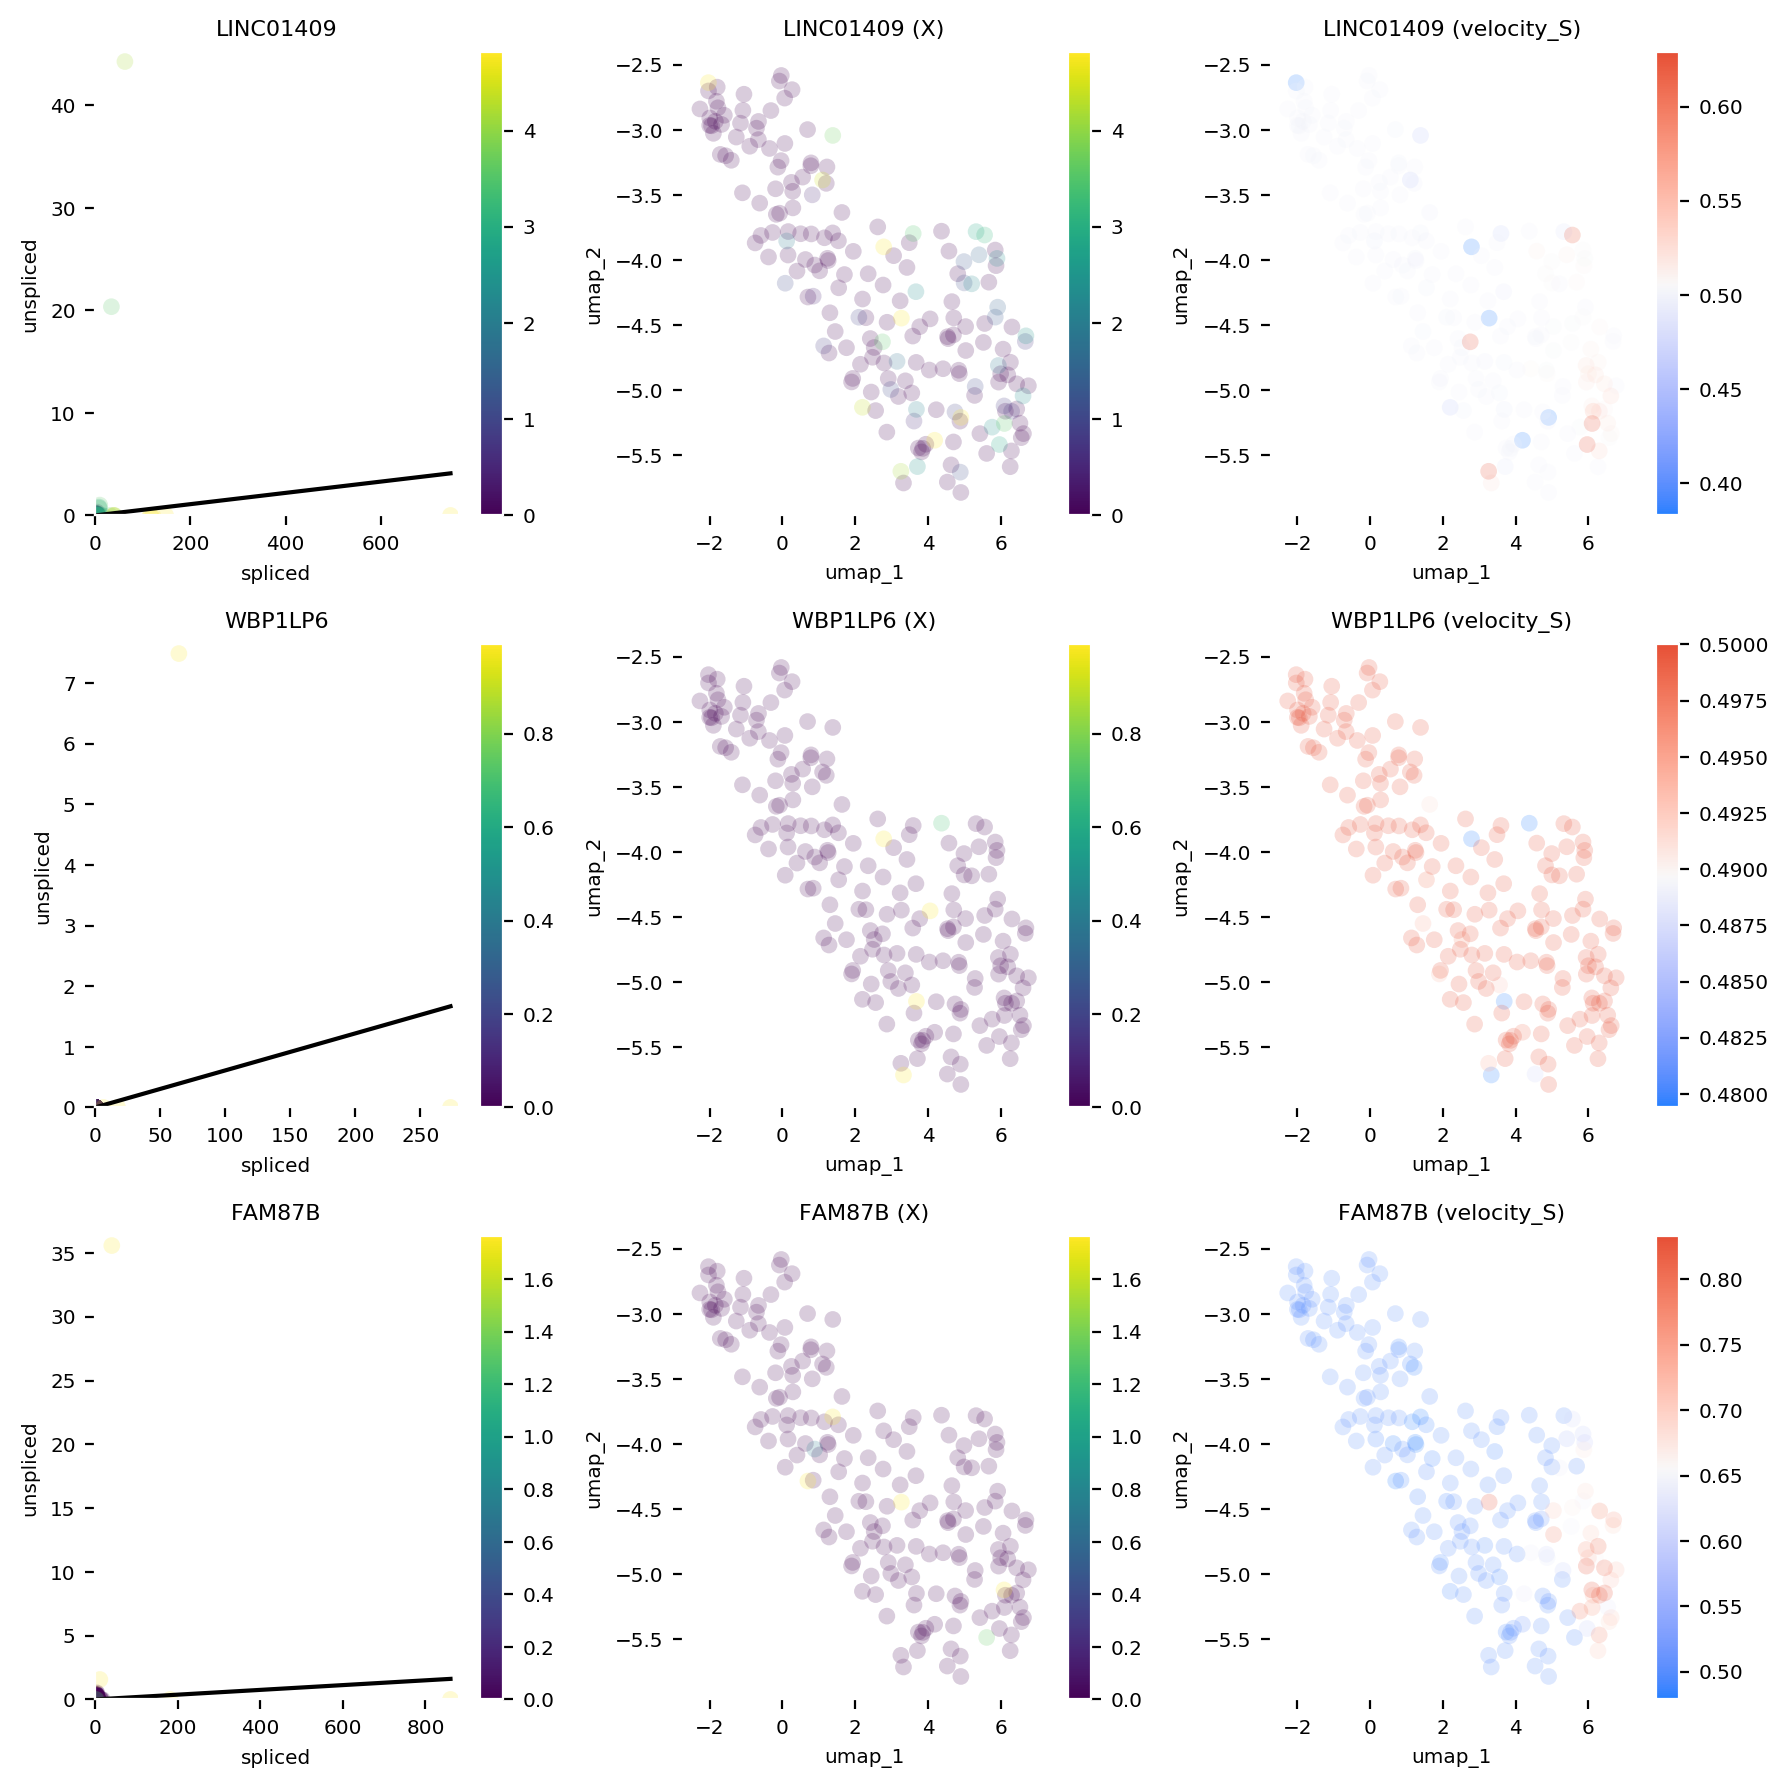

/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 650x500 with 0 Axes>

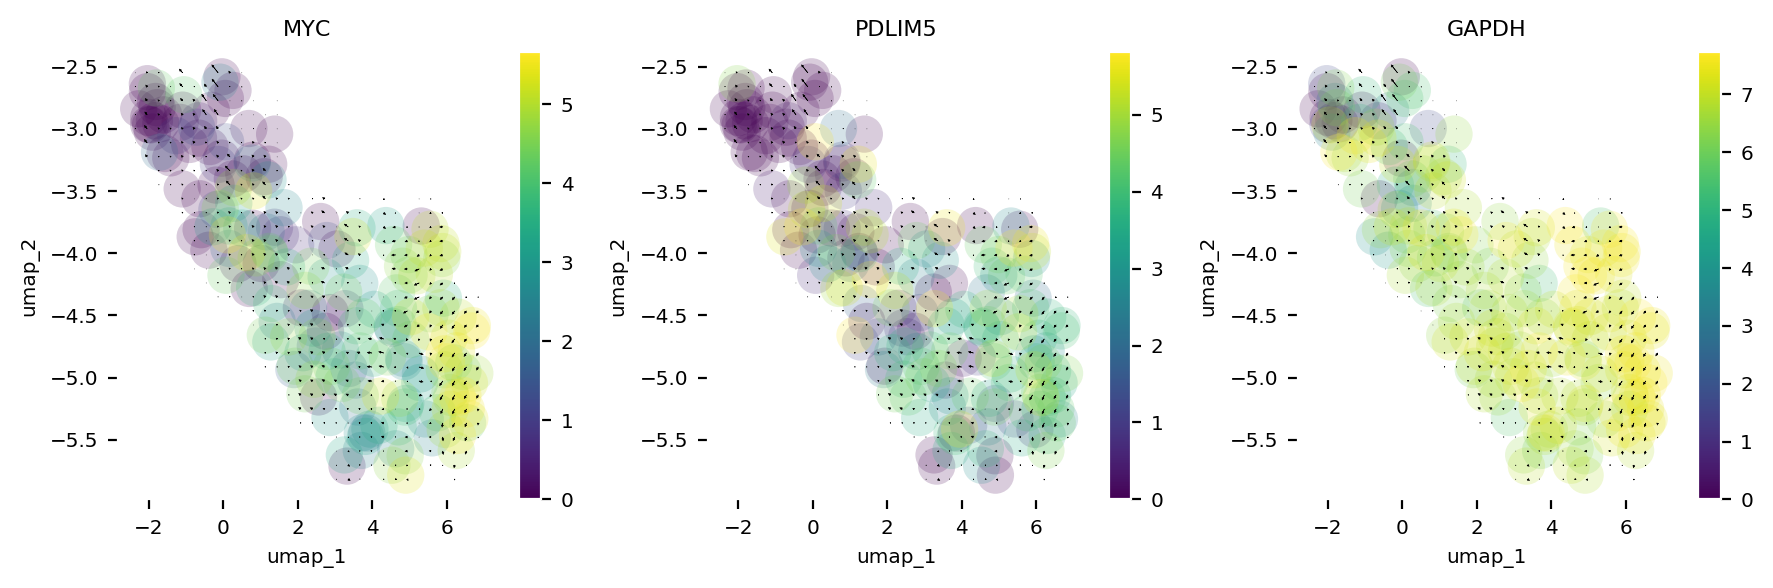

/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


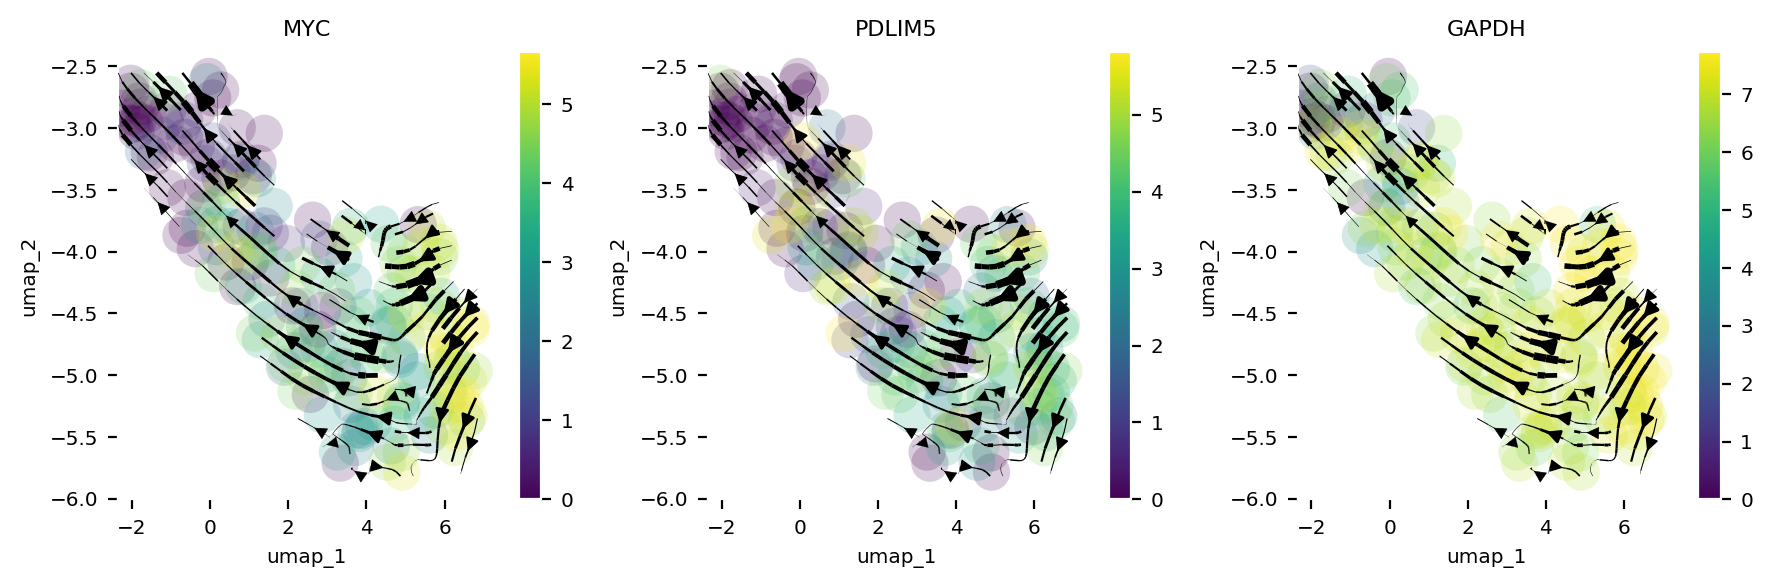

/home/xqiu/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


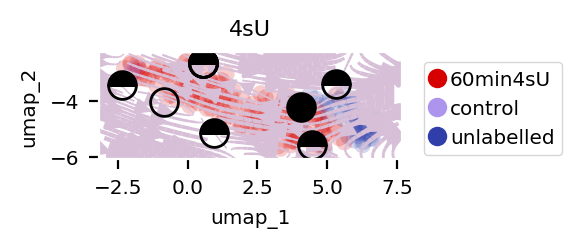

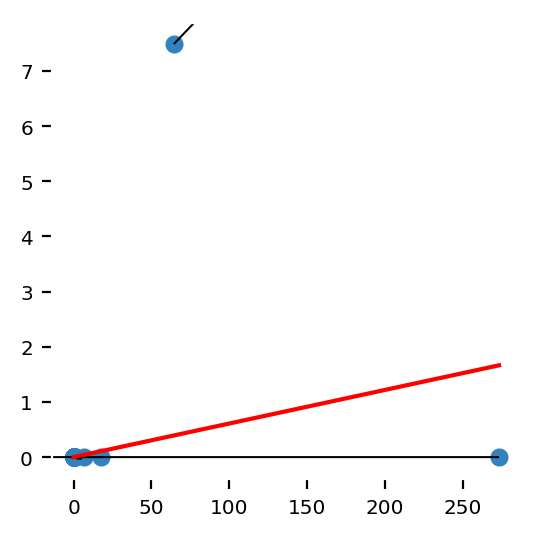

In [8]:
dynamo_analysis(dyn_adata_NASC_seq_1, exp1_gene_list, color='Exp')

In [9]:
dyn_adata_NASC_seq_1.write_h5ad('/home/xqiu/proj/Aristotle/backup/data/dyn_adata_NASC_seq_1.h5ad')

... storing 'Plate' as categorical
... storing 'Well' as categorical
... storing 'Exp' as categorical
... storing 'CellType' as categorical
... storing '4sU' as categorical
... storing '_id' as categorical
... storing 'notfound' as categorical
... storing 'beta' as categorical
... storing 'gamma' as categorical
... storing 'half_life' as categorical
... storing 'alpha_b' as categorical
... storing 'alpha_r2' as categorical
... storing 'gamma_r2' as categorical
... storing 'delta_b' as categorical
... storing 'delta_r2' as categorical
... storing 'uu0' as categorical
... storing 'ul0' as categorical
... storing 'su0' as categorical
... storing 'sl0' as categorical
... storing 'U0' as categorical
... storing 'S0' as categorical
... storing 'total0' as categorical


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


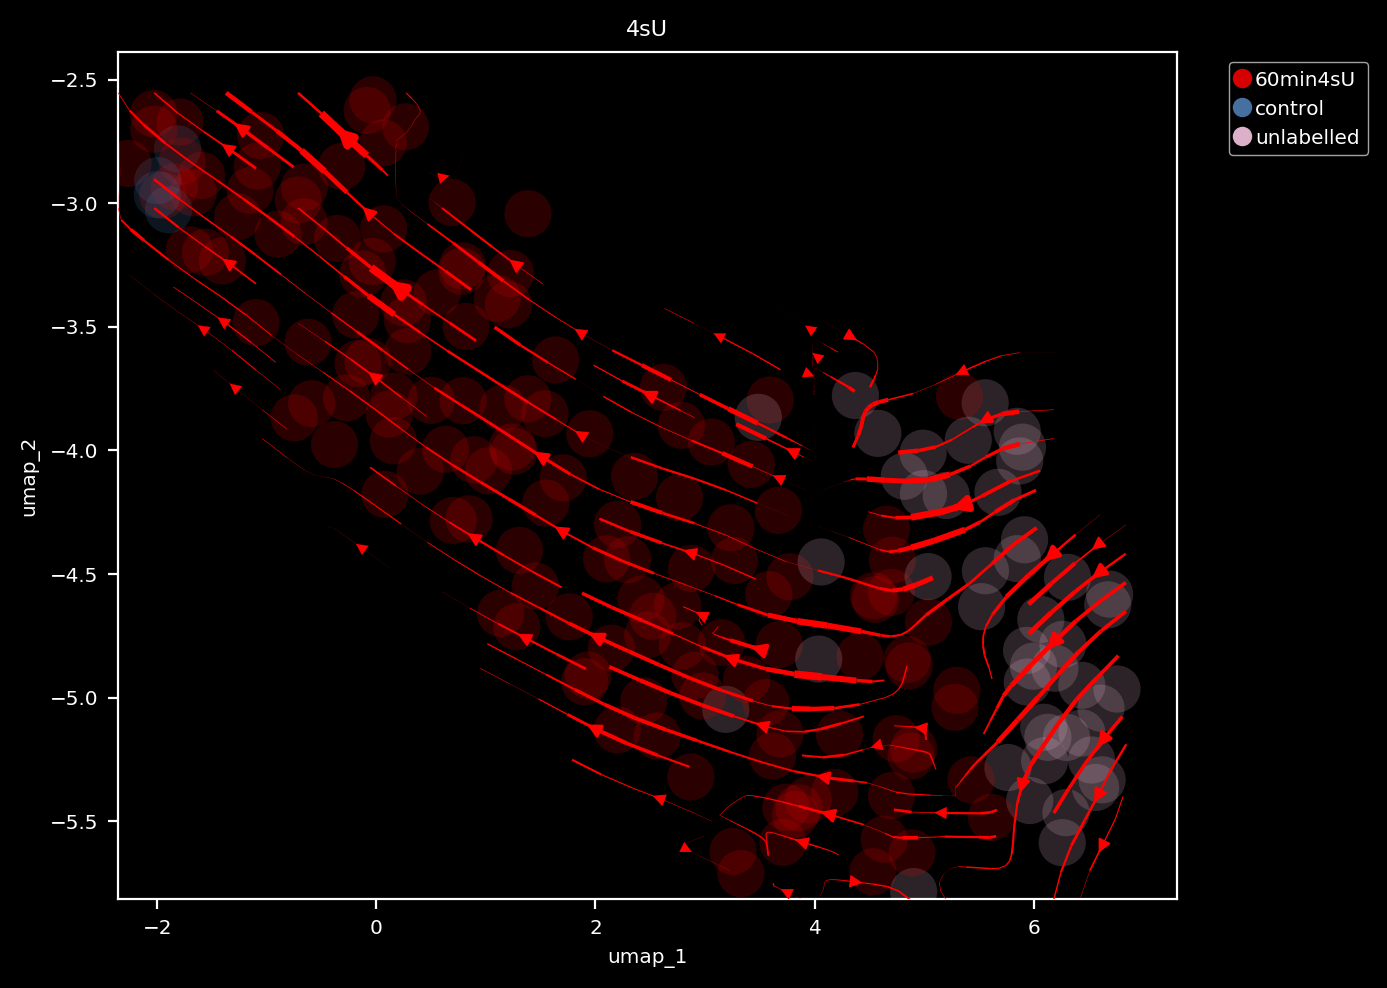

In [10]:
dyn.pl.streamline_plot(dyn_adata_NASC_seq_1, color=['4sU'], basis='umap', background='black') 